In [1]:
!nvidia-smi
!pip install ultralytics kaggle seaborn matplotlib pandas --quiet

import os, yaml, cv2, glob
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from ultralytics import YOLO


Sun Nov  2 12:25:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list -s "road mark detection" | head -n 10


Saving kaggle.json to kaggle.json
ref                                                  title                                           size  lastUpdated                 downloadCount  voteCount  usabilityRating  
---------------------------------------------------  ----------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
pkdarabi/road-mark-detection                         Road Mark Detection                        168881648  2023-11-30 20:11:22.700000           1569         69  1.0              
prakharsinghchouhan/dataset-english                  Road Mark  Detection Dataset - English     168970495  2024-01-13 16:16:58.883000            343          9  0.8125           
trainingdatapro/car-masks                            Vehicle dataset - Images & Segmentation    146084722  2023-08-01 11:26:47.073000            928         12  1.0              
deeppratap/road-mark-detection                       Road Mark Detectio

In [3]:
!kaggle datasets download -d pkdarabi/road-mark-detection
!unzip -q road-mark-detection.zip -d road_mark_detection
!ls road_mark_detection/data


Dataset URL: https://www.kaggle.com/datasets/pkdarabi/road-mark-detection
License(s): Attribution 4.0 International (CC BY 4.0)
road-mark-detection.zip: Skipping, found more recently modified local copy (use --force to force download)
replace road_mark_detection/data.yaml? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
ls: cannot access 'road_mark_detection/data': No such file or directory


In [5]:
# Inspect the extracted files and directories
!ls road_mark_detection/

data.yaml  test  train	valid


In [6]:
yaml_path = "road_mark_detection/data.yaml"
with open(yaml_path) as f:
    data = yaml.safe_load(f)

data['train'] = str(Path("road_mark_detection/train/images").resolve())
data['val'] = str(Path("road_mark_detection/valid/images").resolve())
data['test'] = str(Path("road_mark_detection/test/images").resolve())

with open("data_fixed.yaml", "w") as f:
    yaml.dump(data, f, sort_keys=False)

print("✅ Fixed YAML saved as data_fixed.yaml")

✅ Fixed YAML saved as data_fixed.yaml


In [7]:
model = YOLO("yolov8n.pt")

results = model.train(
    data="data_fixed.yaml",
    epochs=50,
    imgsz=640,
    batch=16,
    name="roadmark_yolov8n",
    device=0,
    patience=10,
    verbose=True
)


Ultralytics 8.3.223 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data_fixed.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=roadmark_yolov8n, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0, plots=True, pose=12.0, p

In [8]:
metrics = model.val()
metrics


Ultralytics 8.3.223 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,008,183 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1402.1±872.9 MB/s, size: 60.8 KB)
val: Scanning /content/road_mark_detection/valid/labels.cache... 417 images, 1 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 417/417 732.4Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 27/27 4.1it/s 6.6s
                   all        417       1966      0.923      0.851       0.91      0.715
              BUS LANE         32         32      0.934          1      0.978      0.771
      Jeltaya razmetka         28         29          1       0.89       0.93      0.709
              Liniya 1        218       1212      0.901      0.592      0.799       0.59
              Liniya 2         25         59       0.85       0.39      0.578      0.302
               Perehod        127   

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x789862ac5ca0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.04504

In [10]:
!mkdir predictions

model.predict(
    source="road_mark_detection/test/images",
    save=True,
    project="predictions",
    name="roadmark_results",
    imgsz=640
)

mkdir: cannot create directory ‘predictions’: File exists

image 1/192 /content/road_mark_detection/test/images/100b_jpg.rf.5518a9f45a7eb2dab98df16d96f223c8.jpg: 640x640 6 Liniya 1s, 2 Rombs, 8.5ms
image 2/192 /content/road_mark_detection/test/images/103_jpg.rf.4e2cd87d24cff067a92ed04f9ea95eb4.jpg: 640x640 5 Liniya 1s, 2 Rombs, 7.3ms
image 3/192 /content/road_mark_detection/test/images/103a_jpg.rf.7cc93cbc0c8b2a8d89b2a03a7f19eb21.jpg: 640x640 4 Liniya 1s, 2 Rombs, 7.3ms
image 4/192 /content/road_mark_detection/test/images/107_jpg.rf.29a741c343edd1f0eb2febb82f61acfe.jpg: 640x640 8 Liniya 1s, 2 Rombs, 7.3ms
image 5/192 /content/road_mark_detection/test/images/112_jpg.rf.c122458fdd30c246e2c6b1644a95da76.jpg: 640x640 5 Liniya 1s, 2 Rombs, 7.3ms
image 6/192 /content/road_mark_detection/test/images/114a_jpg.rf.ccbe2fff01c6fbd7d21b126e5424a607.jpg: 640x640 1 Liniya 1, 1 Strelka vpered, 7.3ms
image 7/192 /content/road_mark_detection/test/images/120_jpg.rf.3f4ff813cfcfdf9a6f76911017956bb3.jpg: 

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'BUS LANE', 1: 'Jeltaya razmetka', 2: 'Liniya 1', 3: 'Liniya 2', 4: 'Perehod', 5: 'Romb', 6: 'SLOW', 7: 'Strelka vlevo', 8: 'Strelka vpered', 9: 'Strelka vpered - vlevo', 10: 'Strelka vpered - vpravo', 11: 'Strelka vpravo', 12: 'Velosiped'}
 obb: None
 orig_img: array([[[176, 185, 195],
         [159, 168, 177],
         [128, 133, 142],
         ...,
         [233, 229, 228],
         [233, 229, 228],
         [231, 229, 228]],
 
        [[160, 169, 179],
         [174, 183, 192],
         [152, 158, 165],
         ...,
         [233, 229, 228],
         [233, 229, 228],
         [231, 229, 228]],
 
        [[ 94, 103, 112],
         [138, 147, 156],
         [153, 159, 166],
         ...,
         [233, 229, 228],
         [233, 229, 228],
         [231, 229, 228]],
 
        ...,
 
        [[119, 151, 146],
         [122, 154, 149],


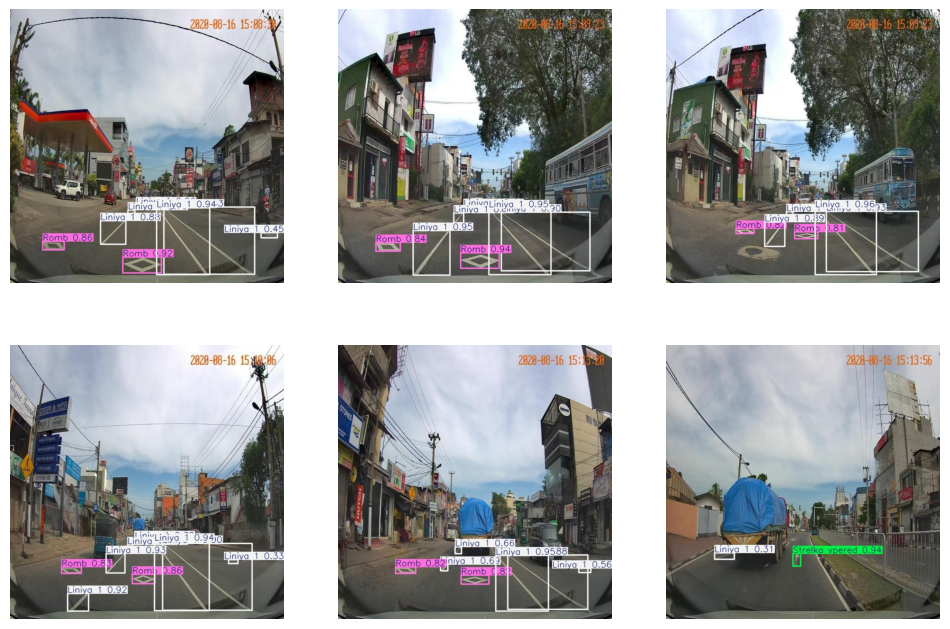

In [11]:
pred_imgs = sorted(glob.glob("predictions/roadmark_results/*.jpg"))

plt.figure(figsize=(12, 8))
for i, img_path in enumerate(pred_imgs[:6]):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()


Ultralytics 8.3.223 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data_fixed.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=1, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=T

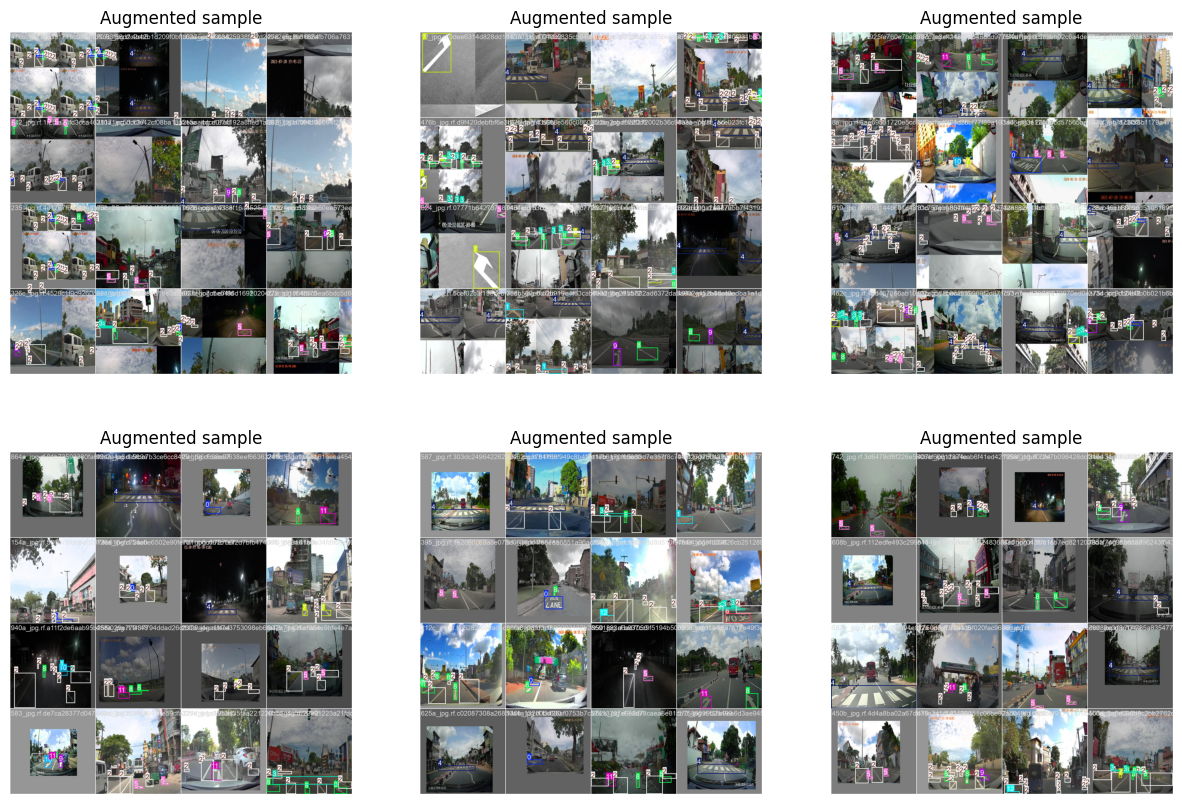

In [12]:
model = YOLO("yolov8n.pt")
dataset = "data_fixed.yaml"

model.train(data=dataset, imgsz=640, epochs=1, plots=True)

aug_dir = sorted(list(Path("runs/detect").glob("*/train_batch*.jpg")))

if aug_dir:
    plt.figure(figsize=(15, 10))
    for i, img_path in enumerate(aug_dir[:6]):
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(2, 3, i + 1)
        plt.imshow(img)
        plt.title("Augmented sample")
        plt.axis("off")
    plt.show()


Ultralytics 8.3.223 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1360.0±566.3 MB/s, size: 60.3 KB)
val: Scanning /content/road_mark_detection/valid/labels.cache... 417 images, 1 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 417/417 409.4Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 27/27 4.4it/s 6.1s
                   all        417       1966      0.468       0.25       0.23      0.133
              BUS LANE         32         32      0.142     0.0625     0.0807     0.0505
      Jeltaya razmetka         28         29      0.526      0.379      0.412      0.203
              Liniya 1        218       1212      0.426      0.512      0.385      0.239
              Liniya 2         25         59          1          0    0.00179   0.000462
               Perehod        127        132      0.479      0.606      0.481      0.184
                  Romb     

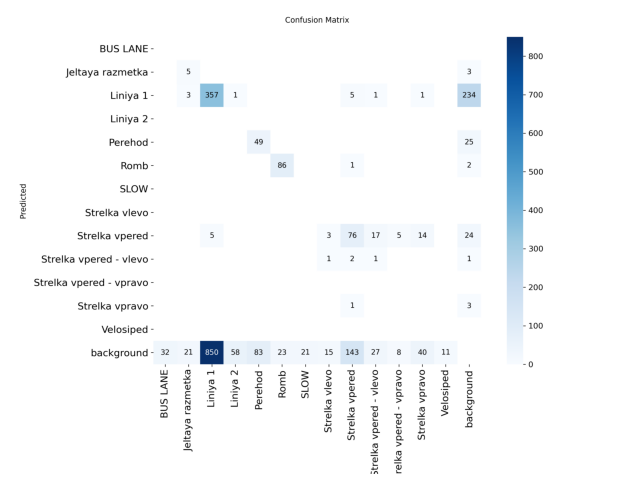

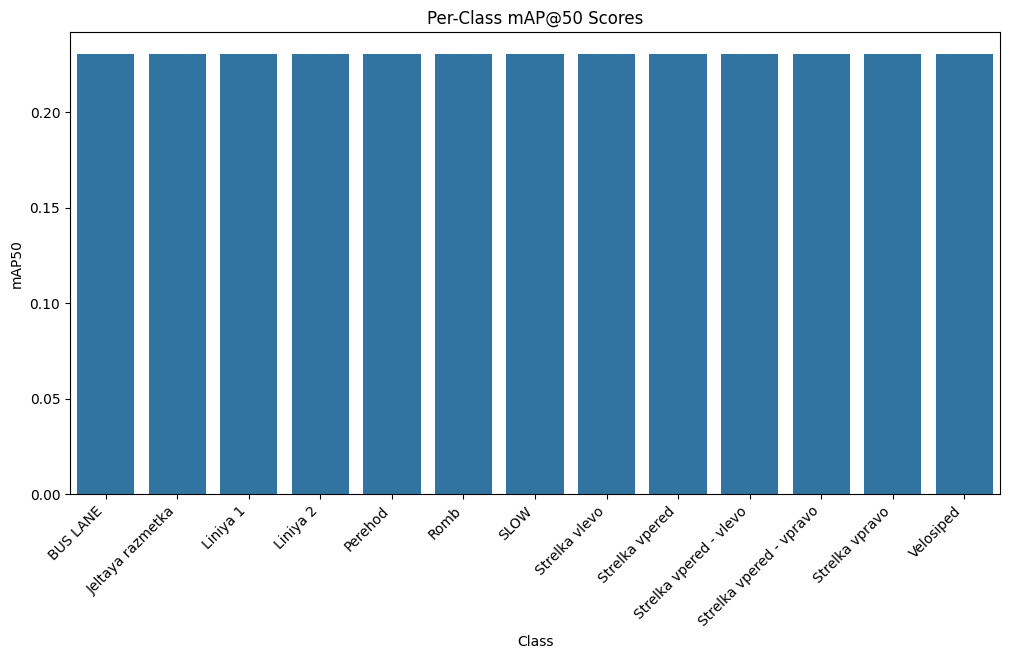

In [15]:
import seaborn as sns
import pandas as pd

metrics = model.val()
results_dict = metrics.results_dict

for k, v in results_dict.items():
    print(f"{k:<20}: {v:.4f}")

cm_path = Path(metrics.save_dir) / "confusion_matrix.png"
if cm_path.exists():
    img = cv2.imread(str(cm_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

if hasattr(metrics, 'results_dict'):
    df = pd.DataFrame({
        'Class': model.names.values(),
        'Precision': metrics.box.p.tolist(),
        'Recall': metrics.box.r.tolist(),
        'mAP50': metrics.box.map50.tolist()
    })
    df = df.sort_values('mAP50', ascending=False)

    plt.figure(figsize=(12, 6))
    sns.barplot(x='Class', y='mAP50', data=df)
    plt.xticks(rotation=45, ha='right')
    plt.title("Per-Class mAP@50 Scores")
    plt.show()

Saving 103_jpg.rf.4e2cd87d24cff067a92ed04f9ea95eb4.jpg to 103_jpg.rf.4e2cd87d24cff067a92ed04f9ea95eb4 (1).jpg

image 1/1 /content/103_jpg.rf.4e2cd87d24cff067a92ed04f9ea95eb4 (1).jpg: 640x640 3 Liniya 1s, 2 Rombs, 16.2ms
Speed: 6.8ms preprocess, 16.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/predictions/custom3


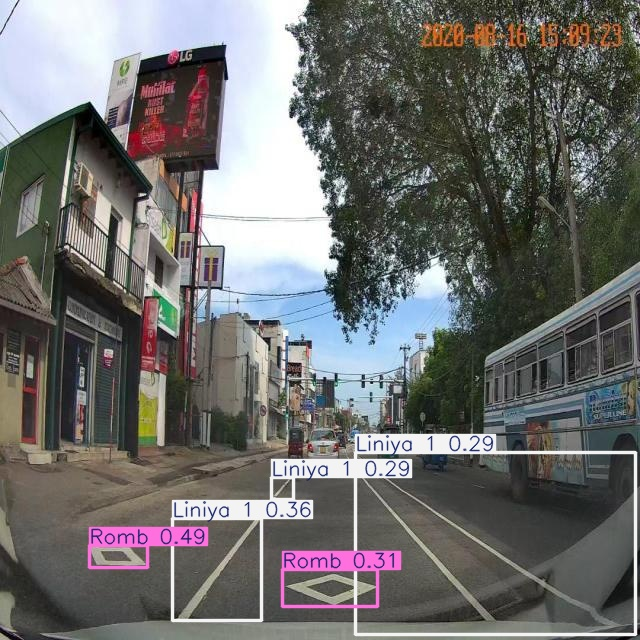

In [18]:
from google.colab import files
from PIL import Image

uploaded = files.upload()
file_name = list(uploaded.keys())[0]

results = model.predict(
    source=file_name,
    save=True,
    project="predictions",
    name="custom"
)

# Get the directory where the results were saved
save_dir = results[0].save_dir

Image.open(f"{save_dir}/{file_name}")

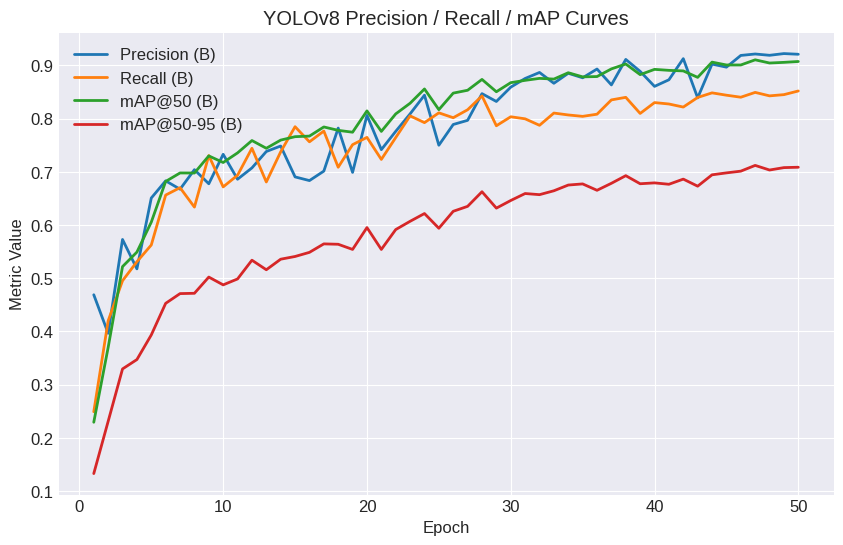

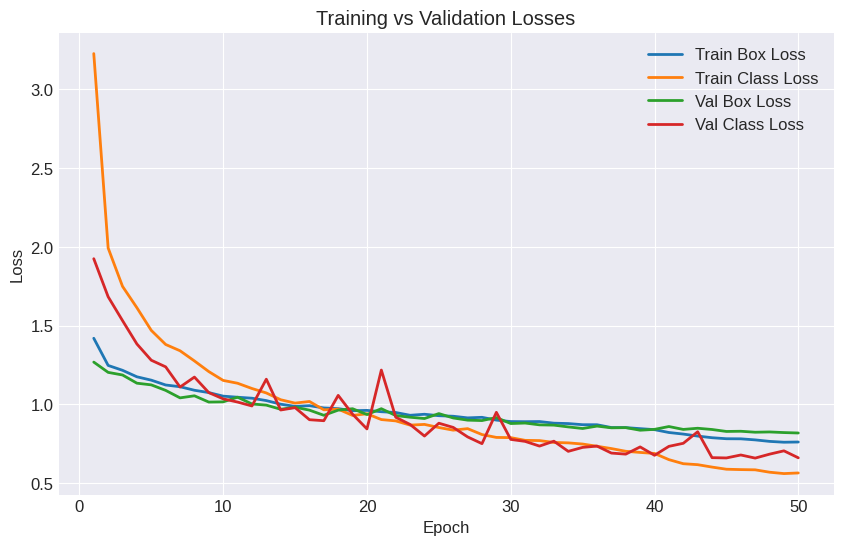

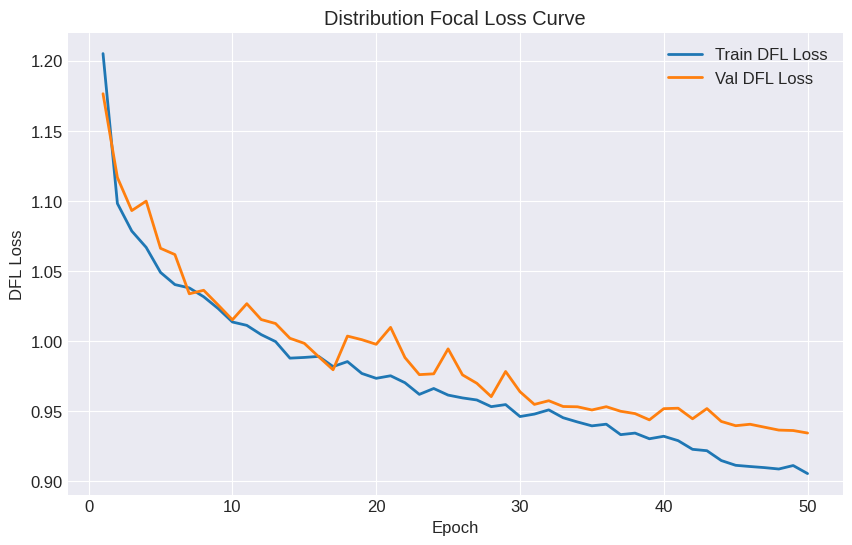

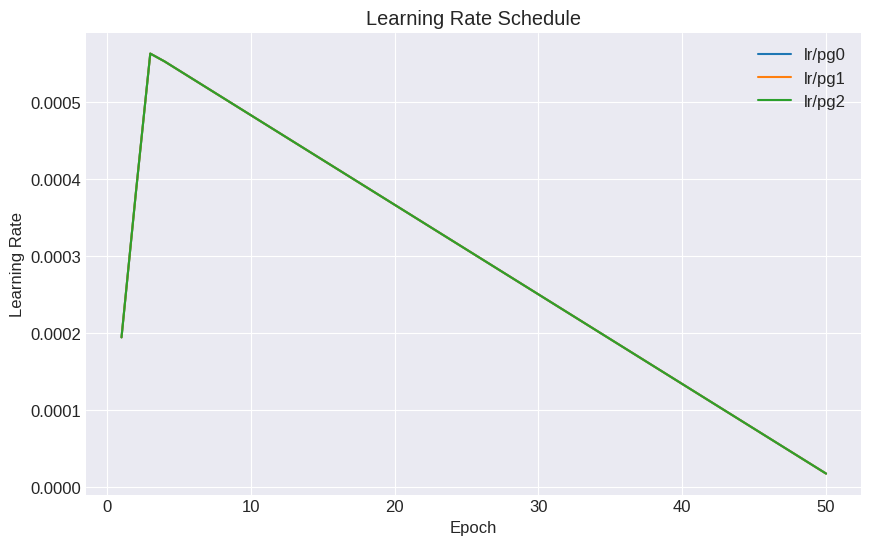

Final Epoch Summary:
metrics/precision(B)     : 0.9208
metrics/recall(B)        : 0.8518
metrics/mAP50(B)         : 0.9072
metrics/mAP50-95(B)      : 0.7085

Best Epoch (by mAP@50): 47
Best mAP@50: 0.9104


In [20]:
# =============================================================
# 📊 YOLOv8 Results Visualization from results.csv
# =============================================================

import pandas as pd
import matplotlib.pyplot as plt

# Load YOLOv8 results
results = pd.read_csv("results.csv")

# Style setup
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# --- 1️⃣ Precision, Recall, mAP50, mAP50-95 Curves ---
plt.figure(figsize=(10,6))
plt.plot(results["epoch"], results["metrics/precision(B)"], label="Precision (B)", linewidth=2)
plt.plot(results["epoch"], results["metrics/recall(B)"], label="Recall (B)", linewidth=2)
plt.plot(results["epoch"], results["metrics/mAP50(B)"], label="mAP@50 (B)", linewidth=2)
plt.plot(results["epoch"], results["metrics/mAP50-95(B)"], label="mAP@50-95 (B)", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Metric Value")
plt.title("YOLOv8 Precision / Recall / mAP Curves")
plt.legend()
plt.grid(True)
plt.show()

# --- 2️⃣ Training and Validation Loss Curves ---
plt.figure(figsize=(10,6))
plt.plot(results["epoch"], results["train/box_loss"], label="Train Box Loss", linewidth=2)
plt.plot(results["epoch"], results["train/cls_loss"], label="Train Class Loss", linewidth=2)
plt.plot(results["epoch"], results["val/box_loss"], label="Val Box Loss", linewidth=2)
plt.plot(results["epoch"], results["val/cls_loss"], label="Val Class Loss", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Losses")
plt.legend()
plt.grid(True)
plt.show()

# --- 3️⃣ DFL (Distribution Focal Loss) Progress ---
plt.figure(figsize=(10,6))
plt.plot(results["epoch"], results["train/dfl_loss"], label="Train DFL Loss", linewidth=2)
plt.plot(results["epoch"], results["val/dfl_loss"], label="Val DFL Loss", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("DFL Loss")
plt.title("Distribution Focal Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

# --- 4️⃣ Learning Rate Curve ---
plt.figure(figsize=(10,6))
plt.plot(results["epoch"], results["lr/pg0"], label="lr/pg0")
plt.plot(results["epoch"], results["lr/pg1"], label="lr/pg1")
plt.plot(results["epoch"], results["lr/pg2"], label="lr/pg2")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")
plt.legend()
plt.grid(True)
plt.show()

# --- 5️⃣ Combined Summary Printout ---
print("Final Epoch Summary:")
final = results.iloc[-1]
for col in ["metrics/precision(B)", "metrics/recall(B)", "metrics/mAP50(B)", "metrics/mAP50-95(B)"]:
    print(f"{col:25}: {final[col]:.4f}")

print(f"\nBest Epoch (by mAP@50): {int(results['epoch'][results['metrics/mAP50(B)'].idxmax()])}")
print(f"Best mAP@50: {results['metrics/mAP50(B)'].max():.4f}")


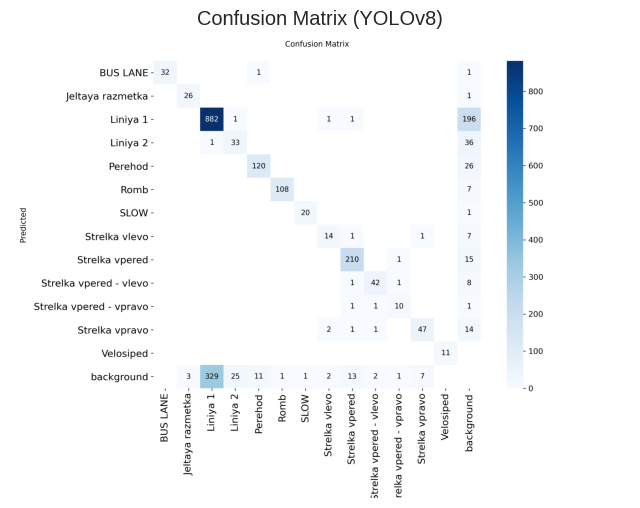

In [22]:
import cv2
import matplotlib.pyplot as plt

cm_path = "/content/runs/detect/roadmark_yolov8n/confusion_matrix.png"
if os.path.exists(cm_path):
    img = cv2.imread(cm_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.title("Confusion Matrix (YOLOv8)")
    plt.axis('off')
    plt.show()
else:
    print("⚠️ Confusion matrix not found in this directory.")
